In [23]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np
import os
from tsne import *

In [24]:
# define model architecture

class ConditioNet(nn.Module):
    def __init__(self, n_class, n_in, n_hid, z_dim):
        super(ConditioNet, self).__init__()

        self.enc1 = nn.Linear(n_in + n_class, n_hid)
        self.enc2m = nn.Linear(n_hid, z_dim)
        self.enc2s = nn.Linear(n_hid, z_dim)
        self.dec1 = nn.Linear(z_dim, n_hid)
        self.dec2 = nn.Linear(n_hid, n_in)

    def encode(self, x):
        h1 = F.relu(self.enc1(x))
        return self.enc2m(h1), self.enc2s(h1)

    def reparameterize(self, mu, logvar):        
        stdev = torch.exp(0.5*logvar)
        eps = torch.randn_like(stdev)
        return mu + eps*stdev

    def decode(self, z):
        h3 = F.relu(self.dec1(z))
        return torch.sigmoid(self.dec2(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [25]:
# load best model
n_class = 10
n_in = 28*28
hyperparams = torch.load("hyperparameters.pth")
best_ind = torch.argmin(hyperparams[:,3])
n_hid_best, z_dim_best, lr_best = [float(elem) for elem in hyperparams[best_ind, :3]]
print(f'Best parameters: n_hid = {n_hid_best}, z_dim = {z_dim_best}, lr = {10**lr_best}')

best_cvae = ConditioNet(int(n_class), int(n_in), int(n_hid_best), int(z_dim_best))
best_cvae.load_state_dict(torch.load("best_cVAE_weights.pth"))

Best parameters: n_hid = 100.0, z_dim = 25.0, lr = 0.001


<All keys matched successfully>

In [91]:
# set up encoded dataset

# Labels for later
master_labels = ["T-shirt", "Pants", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

# Load the FashionMNIST dataset
dataset = torchvision.datasets.FashionMNIST(root='../data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))

# set up data loader
# extract data
data_loader = DataLoader(dataset, batch_size=1024, shuffle=True, num_workers=0)
_, (data_big, target_big) = next(enumerate(data_loader))

data = torch.empty(0,1,28,28)
target = torch.empty(0)

for label in ["Dress", "Coat", "Sandal", "Sneaker"]:
    # subset to label
    # pick first ten elements
    label_num = master_labels.index(label)
    inds = torch.nonzero(target_big == label_num).squeeze()[:32]
    data_sub = data_big[inds,:,:,:]
    target_sub = target_big[inds]
    
    # stack on tensor
    data = torch.cat((data, data_sub))
    target = torch.cat((target, target_sub))
    
# encode to latent representations
data = data.view(data.size(0),-1)
target_onehot = torch.zeros(data.shape[0], 10)
target_onehot[range(data.shape[0]), target.long()] = 1
data_adj = torch.cat((data, target_onehot), dim=1)
data_enc, _, _ = best_cvae(data_adj)

In [92]:
xys = tsne(data_enc.detach().numpy(), initial_dims=784)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 128...
Mean value of sigma: 3.710129
Iteration 10: error is 10.226244
Iteration 20: error is 9.708049
Iteration 30: error is 9.901441
Iteration 40: error is 10.714482
Iteration 50: error is 10.572371
Iteration 60: error is 10.907562
Iteration 70: error is 10.537604
Iteration 80: error is 10.484118
Iteration 90: error is 10.632895
Iteration 100: error is 10.509203
Iteration 110: error is 1.291614
Iteration 120: error is 0.892301
Iteration 130: error is 0.612041
Iteration 140: error is 0.400936
Iteration 150: error is 0.252281
Iteration 160: error is 0.211800
Iteration 170: error is 0.184768
Iteration 180: error is 0.169072
Iteration 190: error is 0.163031
Iteration 200: error is 0.161562
Iteration 210: error is 0.159323
Iteration 220: error is 0.158797
Iteration 230: error is 0.158376
Iteration 240: error is 0.157922
Iteration 250: error is 0.157491
Iteration 260: error is 0.157051
Iter

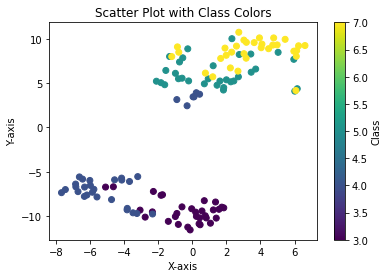

In [93]:
plt.scatter(xys[:, 0], xys[:, 1], c=target, cmap='viridis', marker='o')

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot with Class Colors')

# Add colorbar
cbar = plt.colorbar()
cbar.set_label('Class')

# Show the plot
plt.show()